# Problem Introduction
The problem we will tackle is predicting the max temperature for tomorrow in the city using one year of past weather data.
What we do have access to is one year of historical max temperatures, the temperatures for the previous two days, and an estimate from a friend who is always claiming to know everything about the weather. This is a supervised, regression machine learning problem. It’s supervised because we have both the features (data for the city) and the targets (temperature) that we want to predict. During training, we give the random forest both the features and targets and it must learn how to map the data to a prediction. Moreover, this is a regression task because the target value is continuous

# Data Acquisition
The following Python code loads in the csv data and displays the structure of the data:

In [1]:
# For data manipulation
import pandas as pd
# Read in data and display first 5 rows
features = pd.read_csv('temps.csv')
# drop the columns that contains forecast values
features.drop(['forecast_noaa','forecast_acc','forecast_under'], axis=1, inplace=True)
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


## Following are explanations of the columns:
### year: 
2016 for all data points
### month: 
number for month of the year
### day: 
number for day of the year
### week: 
day of the week as a character string
### temp_2: 
max temperature 2 days prior
### temp_1: 
max temperature 1 day prior
### average: 
historical average max temperature
### actual: 
max temperature measurement
### friend:
a friend's prediction, a random number between 20 below the average and 20 above the average

# Identify Anomalies/ Missing Data
If we look at the dimensions of the data, we notice only there are only 348 rows, which doesn’t quite agree with the 366 days we know there were in 2016.
We also can see there are twelve columns which represent eight features and the one target (‘actual’).

In [2]:
print('The shape of our features is:', features.shape)


The shape of our features is: (348, 9)


To identify anomalies, we can quickly compute summary statistics.

In [3]:
features.describe()

,year,month,day,temp_2,temp_1,average,actual,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,95.000000


# Data Preparation

We will need to do some minor modification to put our data into machine-understandable terms. 
for that we will use:
## One-Hot Encoding
This process takes categorical variables, such as days of the week and converts it to a numerical representation without an arbitrary ordering.
we change the single column of weekdays into seven columns of binary data.
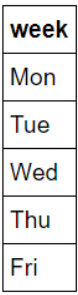
into




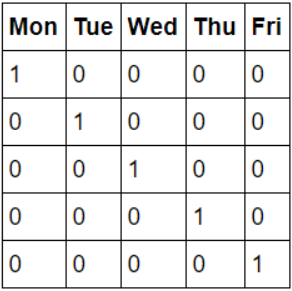

In [4]:
# One-hot encode the data using pandas get_dummies
features = pd.get_dummies(features)
# Display the first 5 rows of the last 12 columns
features.iloc[:,8:].head(5)


,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0


In [5]:
print("the shape now is: ", features.shape)

the shape now is:  (348, 15)


## Features and Targets and Convert Data to Arrays
Now, we need to separate the data into the features and targets. The target, also known as the label, is the value we want to predict, in this case the actual max temperature and the features are all the columns the model uses to make a prediction. We will also convert the Pandas dataframes to Numpy arrays because that is the way the algorithm works. (I save the column headers, which are the names of the features, to a list to use for later visualization).

In [6]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we want to predict
y = np.array(features['actual'])
# Remove the labels from the features
# axis 1 refers to the columns
X = features.drop('actual', axis = 1)
# Saving feature names for later use
feature_list = list(X.columns)
# Convert to numpy array
X = np.array(X)

In [8]:
print(X)

[[2.016e+03 1.000e+00 1.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.016e+03 1.000e+00 2.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.016e+03 1.000e+00 3.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [2.016e+03 1.200e+01 2.900e+01 ... 1.000e+00 0.000e+00 0.000e+00]
 [2.016e+03 1.200e+01 3.000e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.016e+03 1.200e+01 3.100e+01 ... 0.000e+00 0.000e+00 0.000e+00]]


## Training and Testing Sets
There is one final step of data preparation: splitting data into training and testing sets. During training, we let the model ‘see’ the answers, in this case the actual temperature, so it can learn how to predict the temperature from the features. We expect there to be some relationship between all the features and the target value, and the model’s job is to learn this relationship during training. Then, when it comes time to evaluate the model, we ask it to make predictions on a testing set where it only has access to the features, we can compare these predictions to the true value to judge how accurate the model is. Generally, when training a model, we randomly split the data into training and testing sets to get a representation of all data points

In [9]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state = 0)

We can look at the shape of all the data to make sure we did everything correctly. We expect the training features number of columns to match the testing feature number of columns and the number of rows to match for the respective training and testing features and the labels :

In [10]:
print('Training Features Shape:', train_X.shape)
print('Training Labels Shape:', train_y.shape)
print('Testing Features Shape:', test_X.shape)
print('Testing Labels Shape:', test_y.shape)

Training Features Shape: (261, 14)
Training Labels Shape: (261,)
Testing Features Shape: (87, 14)
Testing Labels Shape: (87,)


# Train Model 
We import the random forest regression model from skicit-learn, instantiate the model, and fit the model on the training data.

In [13]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
model = RandomForestRegressor(n_estimators = 1000, random_state = 0)
# Train the model on training data
model.fit(train_X, train_y)

RandomForestRegressor(n_estimators=1000, random_state=0)

# Make Predictions on the Test Set
Our model has now been trained to learn the relationships between the features and the targets. The next step is figuring out how good the model is! To do this we make predictions on the test features.
We then compare the predictions to the known answers.

In [14]:
# Use the forest's predict method on the test data
predictions = model.predict(test_X)
# Calculate the absolute errors
errors = abs(predictions - test_y)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 3.78 degrees.


# Determine Performance Metrics
To put our predictions in perspective, we can calculate an accuracy using the mean average percentage error subtracted from 100 %.

In [18]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_y)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Accuracy: 93.92 %.


Our model has learned how to predict the maximum temperature for the next day with 94% accuracy.